In [1]:
import os
import zipfile
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse

In [2]:
def setup_dataset():
    """
    Setup using the local MIND small dataset files
    """
    # Create directories if they don't exist
    os.makedirs('MIND_small/train', exist_ok=True)
    os.makedirs('MIND_small/dev', exist_ok=True)

    # Extract training set if needed
    if not os.path.exists('MIND_small/train/behaviors.tsv'):
        print("Extracting MIND small training set...")
        try:
            with zipfile.ZipFile('MINDsmall_train.zip') as zip_ref:
                zip_ref.extractall('MIND_small/train')
            print("MIND small training set extracted.")
        except zipfile.BadZipFile as e:
            print(f"Error: The training set file is not a valid ZIP: {e}")
            return None
    else:
        print("MIND small training set already extracted.")

    # Extract validation set if needed
    if not os.path.exists('MIND_small/dev/behaviors.tsv'):
        print("Extracting MIND small validation set...")
        try:
            with zipfile.ZipFile('MINDsmall_dev.zip') as zip_ref:
                zip_ref.extractall('MIND_small/dev')
            print("MIND small validation set extracted.")
        except zipfile.BadZipFile as e:
            print(f"Error: The validation set file is not a valid ZIP: {e}")
            return None
    else:
        print("MIND small validation set already extracted.")

    return {
        'train_dir': 'MIND_small/train',
        'dev_dir': 'MIND_small/dev'
    }

In [3]:
def load_behaviors(file_path):
    """Load user behavior data"""
    columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']
    behaviors = pd.read_csv(file_path, sep='\t', names=columns)
    return behaviors

def load_news(file_path):
    """Load news data"""
    columns = ['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']
    news = pd.read_csv(file_path, sep='\t', names=columns)
    return news

def process_impressions(behaviors_df):
    """Convert impressions to user-item interactions with labels"""
    user_item_pairs = []

    for _, row in behaviors_df.iterrows():
        user_id = row['user_id']
        history = row['history'].split() if isinstance(row['history'], str) and pd.notna(row['history']) else []

        if isinstance(row['impressions'], str):
            for impression in row['impressions'].split():
                parts = impression.split('-')
                if len(parts) == 2:
                    news_id, label = parts
                    user_item_pairs.append({
                        'user_id': user_id,
                        'news_id': news_id,
                        'label': int(label),
                        'history': history
                    })

    return pd.DataFrame(user_item_pairs)

def extract_news_features(news_df):
    """Extract text features from news articles"""
    news_features = {}

    for _, row in news_df.iterrows():
        news_id = row['news_id']

        category = row['category'] if pd.notna(row['category']) else ""
        subcategory = row['subcategory'] if pd.notna(row['subcategory']) else ""
        title = row['title'] if pd.notna(row['title']) else ""
        abstract = row['abstract'] if pd.notna(row['abstract']) else ""

        news_features[news_id] = {
            'category': category,
            'subcategory': subcategory,
            'title': title,
            'abstract': abstract
        }

    return news_features

In [4]:
class NewsEncoder(nn.Module):
    def __init__(self, vocab_size=50000, embedding_dim=100, hidden_dim=128):
        super(NewsEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        # x is the token ids
        embedded = self.embedding(x).mean(dim=1)  # Simple mean pooling
        h1 = self.relu(self.fc1(embedded))
        out = self.fc2(h1)
        return out

class UserEncoder(nn.Module):
    def __init__(self, hidden_dim=128):
        super(UserEncoder, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, news_embeddings):
        # news_embeddings: batch_size x history_length x hidden_dim
        attention_weights = self.attention(news_embeddings)  # batch_size x history_length x 1
        weighted_embeddings = news_embeddings * attention_weights  # Element-wise multiplication
        user_embedding = torch.sum(weighted_embeddings, dim=1)  # Sum along history dimension
        return user_embedding

class NewsRecommendationModel(nn.Module):
    def __init__(self, news_encoder, user_encoder):
        super(NewsRecommendationModel, self).__init__()
        self.news_encoder = news_encoder
        self.user_encoder = user_encoder

    def forward(self, history_news, candidate_news):
        # Encode history news
        batch_size = history_news.size(0)
        history_length = history_news.size(1)

        # Reshape for processing
        h_news = history_news.view(batch_size * history_length, -1)

        # Encode all history news at once
        h_news_embeddings = self.news_encoder(h_news)

        # Reshape back
        history_news_embeddings = h_news_embeddings.view(batch_size, history_length, -1)

        # Encode user
        user_embedding = self.user_encoder(history_news_embeddings)

        # Encode candidate news
        candidate_embedding = self.news_encoder(candidate_news)

        # Calculate score (dot product)
        score = torch.sum(user_embedding * candidate_embedding, dim=1)

        return torch.sigmoid(score)


In [5]:
class SimpleTokenizer:
    def __init__(self, max_vocab_size=50000, min_freq=5):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = {}
        self.vocab_size = 2  # PAD and UNK

    def fit(self, texts):
        """Build vocabulary from texts"""
        # Count word frequencies
        for text in texts:
            for word in text.lower().split():
                self.word_freq[word] = self.word_freq.get(word, 0) + 1

        # Filter by frequency and sort
        valid_words = [(word, freq) for word, freq in self.word_freq.items()
                       if freq >= self.min_freq]
        valid_words.sort(key=lambda x: x[1], reverse=True)

        # Build vocabulary limited by max size
        for word, _ in valid_words[:self.max_vocab_size - 2]:  # -2 for PAD and UNK
            self.word2idx[word] = self.vocab_size
            self.idx2word[self.vocab_size] = word
            self.vocab_size += 1

        print(f"Vocabulary size: {self.vocab_size}")

    def tokenize(self, text, max_length=30):
        """Convert text to token ids with padding/truncation"""
        if not text:
            return torch.tensor([0] * max_length)

        words = text.lower().split()
        tokens = [self.word2idx.get(word, 1) for word in words]  # 1 is UNK

        # Truncate or pad
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
        else:
            tokens = tokens + [0] * (max_length - len(tokens))  # 0 is PAD

        return torch.tensor(tokens)

In [6]:
class SimpleNewsDataset(Dataset):
    def __init__(self, interactions_df, news_features, tokenizer, max_history=20, max_title_length=30):
        self.interactions = interactions_df
        self.news_features = news_features
        self.tokenizer = tokenizer
        self.max_history = max_history
        self.max_title_length = max_title_length

        # Create user to history mapping
        self.user_history = {}
        for _, row in interactions_df.iterrows():
            user_id = row['user_id']
            if user_id not in self.user_history:
                self.user_history[user_id] = row['history']

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        row = self.interactions.iloc[idx]
        user_id = row['user_id']
        news_id = row['news_id']
        label = row['label']

        # Get history
        history = self.user_history.get(user_id, [])[:self.max_history]

        # Pad history if needed
        if len(history) < self.max_history:
            history = history + ['PAD'] * (self.max_history - len(history))

        # Process candidate news
        candidate_title = self.news_features.get(news_id, {}).get('title', '')
        candidate_tokens = self.tokenizer.tokenize(candidate_title, self.max_title_length)

        # Process history news
        history_tokens_list = []
        for h_news_id in history:
            if h_news_id == 'PAD':
                history_title = ''
            else:
                history_title = self.news_features.get(h_news_id, {}).get('title', '')

            history_tokens = self.tokenizer.tokenize(history_title, self.max_title_length)
            history_tokens_list.append(history_tokens)

        # Stack history tokens
        history_tokens = torch.stack(history_tokens_list)

        return {
            'history_tokens': history_tokens,
            'candidate_tokens': candidate_tokens,
            'label': torch.tensor(label, dtype=torch.float)
        }


In [7]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=1, device='cpu'):
    model = model.to(device)

    best_val_auc = 0
    train_losses = []
    val_aucs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move batch to device
            history_tokens = batch['history_tokens'].to(device)
            candidate_tokens = batch['candidate_tokens'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            optimizer.zero_grad()

            scores = model(history_tokens, candidate_tokens)

            # Calculate loss
            loss = criterion(scores, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation phase
        model.eval()
        all_scores = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # Move batch to device
                history_tokens = batch['history_tokens'].to(device)
                candidate_tokens = batch['candidate_tokens'].to(device)
                labels = batch['label'].to(device)

                scores = model(history_tokens, candidate_tokens)

                all_scores.extend(scores.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate AUC
        val_auc = roc_auc_score(all_labels, all_scores)
        val_aucs.append(val_auc)

        # Calculate average loss
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val AUC: {val_auc:.4f}")

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_news_model.pth')
            print(f"New best model saved with AUC: {val_auc:.4f}")

    return train_losses, val_aucs


In [8]:
def recommend_news(model, user_id, user_history, candidate_news_ids, news_features, tokenizer, top_k=5, device='cpu'):
    model = model.to(device)
    model.eval()

    max_history = 20

    # Process user history
    history = user_history[:max_history]
    if len(history) < max_history:
        history += ['PAD'] * (max_history - len(history))

    history_tokens_list = []
    for h_news_id in history:
        title = news_features.get(h_news_id, {}).get('title', '') if h_news_id != 'PAD' else ''
        tokens = tokenizer.tokenize(title)
        history_tokens_list.append(tokens)

    history_tokens = torch.stack(history_tokens_list).unsqueeze(0).repeat(len(candidate_news_ids), 1, 1).to(device)

    candidate_tokens_list = []
    for news_id in candidate_news_ids:
        title = news_features.get(news_id, {}).get('title', '')
        candidate_tokens = tokenizer.tokenize(title)
        candidate_tokens_list.append(candidate_tokens)

    candidate_tokens = torch.stack(candidate_tokens_list).to(device)

    with torch.no_grad():
        scores = model(history_tokens, candidate_tokens).cpu().numpy()

    candidate_scores = list(zip(candidate_news_ids, scores))
    candidate_scores.sort(key=lambda x: x[1], reverse=True)
    recommended_news = [news_id for news_id, _ in candidate_scores[:top_k]]

    return recommended_news

In [9]:
def main(args):
    # Setup dataset
    data_dirs = setup_dataset()

    # Load data
    print("Loading and processing data...")

    # Load training data
    train_behaviors = load_behaviors(os.path.join(data_dirs['train_dir'], 'behaviors.tsv'))
    train_news = load_news(os.path.join(data_dirs['train_dir'], 'news.tsv'))

    # Load validation data
    dev_behaviors = load_behaviors(os.path.join(data_dirs['dev_dir'], 'behaviors.tsv'))
    dev_news = load_news(os.path.join(data_dirs['dev_dir'], 'news.tsv'))

    # Process impressions
    train_interactions = process_impressions(train_behaviors)
    dev_interactions = process_impressions(dev_behaviors)

    # Extract news features
    train_news_features = extract_news_features(train_news)
    dev_news_features = extract_news_features(dev_news)

    # Combine news features
    all_news_features = {**train_news_features, **dev_news_features}

    # Get all news titles for tokenizer training
    all_titles = [news['title'] for news in all_news_features.values() if news['title']]

    # Initialize tokenizer
    print("Building vocabulary...")
    tokenizer = SimpleTokenizer(max_vocab_size=args.vocab_size, min_freq=args.min_freq)
    tokenizer.fit(all_titles)

    # Initialize model
    print("Initializing model...")
    news_encoder = NewsEncoder(
        vocab_size=tokenizer.vocab_size,
        embedding_dim=args.embedding_dim,
        hidden_dim=args.hidden_dim
    )
    user_encoder = UserEncoder(hidden_dim=args.hidden_dim)
    model = NewsRecommendationModel(news_encoder, user_encoder)

    # Create datasets
    print("Creating datasets...")
    train_dataset = SimpleNewsDataset(
        train_interactions,
        all_news_features,
        tokenizer,
        max_history=args.max_history
    )
    dev_dataset = SimpleNewsDataset(
        dev_interactions,
        all_news_features,
        tokenizer,
        max_history=args.max_history
    )

    # Create dataloaders
    # train_loader = DataLoader(
    #     train_dataset,
    #     batch_size=args.batch_size,
    #     shuffle=True
    # )
    # dev_loader = DataLoader(
    #     dev_dataset,
    #     batch_size=args.batch_size * 4,
    #     shuffle=False
    # )

        # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    dev_loader = DataLoader(
        dev_dataset,
        batch_size=args.batch_size * 4,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Set up optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    criterion = nn.BCELoss()

    # Train model
    if not args.eval_only:
        print("Training model...")
        train_losses, val_aucs = train_model(
            model,
            train_loader,
            dev_loader,
            optimizer,
            criterion,
            epochs=args.epochs,
            device=args.device
        )

        # Plot training progress
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        plt.plot(val_aucs)
        plt.title('Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')

        plt.tight_layout()
        plt.savefig('training_progress.png')

    # Load best model for evaluation
    if os.path.exists('best_news_model.pth'):
        model.load_state_dict(torch.load('best_news_model.pth'))

    # Example recommendation
    print("\nGenerating example recommendations...")
    sample_users = dev_interactions['user_id'].unique()[:5]

    for user_id in sample_users:
        user_data = dev_interactions[dev_interactions['user_id'] == user_id]
        sample_history = user_data.iloc[0]['history']

        # Get all candidate news for this user
        candidate_news_ids = list(set(user_data['news_id']))

        # Get recommendations
        recommendations = recommend_news(
            model,
            user_id,
            sample_history,
            candidate_news_ids,
            all_news_features,
            tokenizer,
            top_k=5,
            device=args.device
        )

        # Print recommendations
        print(f"\nRecommended news for user {user_id}:")
        for i, news_id in enumerate(recommendations):
            title = all_news_features.get(news_id, {}).get('title', 'Unknown')
            category = all_news_features.get(news_id, {}).get('category', 'Unknown')
            print(f"{i+1}. [{category}] {title}")

            # Print if it was clicked by user (validation)
            user_labels = user_data[user_data['news_id'] == news_id]['label']
            if not user_labels.empty:
                label = user_labels.iloc[0]
                print(f"   User clicked: {'Yes' if label == 1 else 'No'}")

Extracting MIND small training set...
MIND small training set extracted.
Extracting MIND small validation set...
MIND small validation set extracted.
Loading and processing data...
Building vocabulary...
Vocabulary size: 20677
Initializing model...
Creating datasets...
Training model...


Validation: 100%|██████████| 10708/10708 [04:58<00:00, 35.82it/s]


Epoch 1/1, Loss: 0.1643, Val AUC: 0.5952
New best model saved with AUC: 0.5952

Generating example recommendations...

Recommended news for user U80234:
1. [news] Kentucky woman charged in death of woman missing since May
   User clicked: No
2. [sports] Report: Myles Garrett facing lengthy suspension, could be five games
   User clicked: No
3. [sports] Report: Police investigating woman's death after Redskins' player Montae Nicholson took her to hospital
   User clicked: No
4. [finance] Raise Billions From Billionaires? Tax Experts Say It's Not That Simple
   User clicked: No
5. [sports] This was uglier than a brawl. And Myles Garrett deserves suspension for rest of year after helmet attack.
   User clicked: No

Recommended news for user U60458:
1. [lifestyle] Queen Elizabeth Just Rode Horseback at Age 93
   User clicked: No
2. [travel] Maze of tunnels reveals remains of ancient Jerusalem
   User clicked: No
3. [finance] Raise Billions From Billionaires? Tax Experts Say It's Not That S

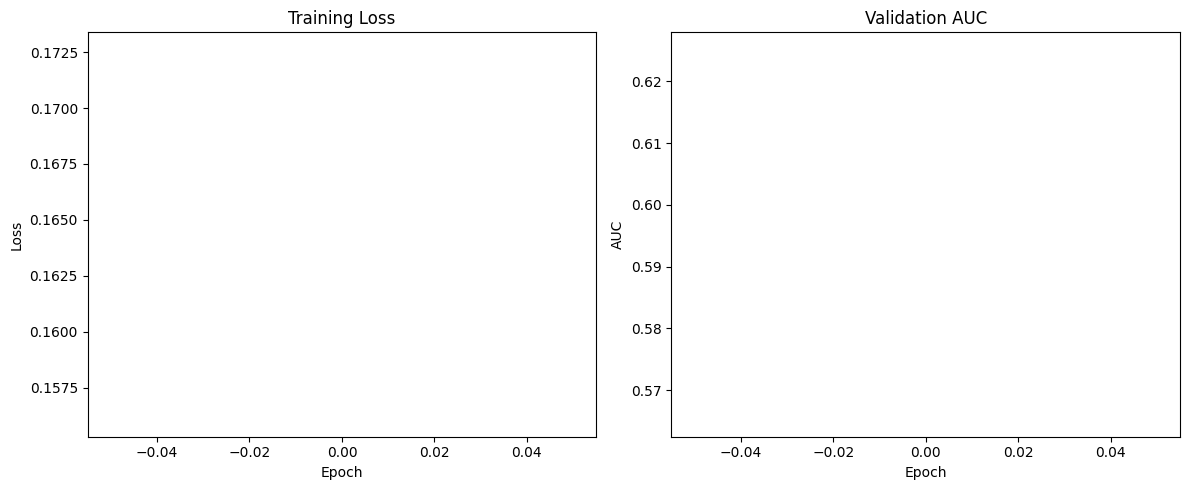

In [10]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='News Recommendation System')

    # Data parameters
    parser.add_argument('--force_download', action='store_true', help='Force download dataset even if already exists')

    # Model parameters
    parser.add_argument('--vocab_size', type=int, default=50000, help='Size of vocabulary')
    parser.add_argument('--embedding_dim', type=int, default=100, help='Embedding dimension')
    parser.add_argument('--hidden_dim', type=int, default=128, help='Hidden dimension')
    parser.add_argument('--max_history', type=int, default=20, help='Maximum history length')
    parser.add_argument('--min_freq', type=int, default=3, help='Minimum word frequency')

    # Training parameters
    parser.add_argument('--batch_size', type=int, default=64, help='Batch size')
    parser.add_argument('--epochs', type=int, default=1, help='Number of epochs')
    parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate')
    parser.add_argument('--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu', help='Device')
    parser.add_argument('--eval_only', action='store_true', help='Only evaluate model')

    # This is the key change: ignore unknown arguments that Jupyter might pass
    args, unknown = parser.parse_known_args()

    main(args)